<h4>Features 17-04-2024</h4>

In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="MDABTC", time="2021-11-23 15:00:24", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    start: pd.Timestamp = pump.time.floor("1h") - lookback_delta
    end: pd.Timestamp = pump.time.floor("1h")

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(
                ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name
            )
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")

    df = df[
        (df["time"] >= start) & (df["time"] < end - timedelta(minutes=30))
    ].reset_index(drop=True)

    return df

In [4]:
df: pd.DataFrame = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["price"] * df["qty"]
df.head()

,price,qty,time,isBuyerMaker,quote
0,0.000013,293.0,2021-10-24 15:01:10.239,False,0.003912
1,0.000013,14.0,2021-10-24 15:02:28.510,True,0.000187
2,0.000013,172.0,2021-10-24 15:03:26.185,False,0.002296
3,0.000013,14.0,2021-10-24 15:04:02.979,True,0.000187
4,0.000013,373.0,2021-10-24 15:05:42.690,True,0.004976


<h4>Create features</h4>

<p>Create trades from ticks by aggregation by time </p>

In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]

df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
    # Add BTC slippage
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0
df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long
0,2021-10-24 15:01:10.239,0.000013,0.000013,0.000013,0.000013,293.0,293.0,0.003912,0.003912,True
1,2021-10-24 15:02:28.510,0.000013,0.000013,0.000013,0.000013,-14.0,14.0,-0.000187,0.000187,False


<h4>Plot candlestick plot</h4>

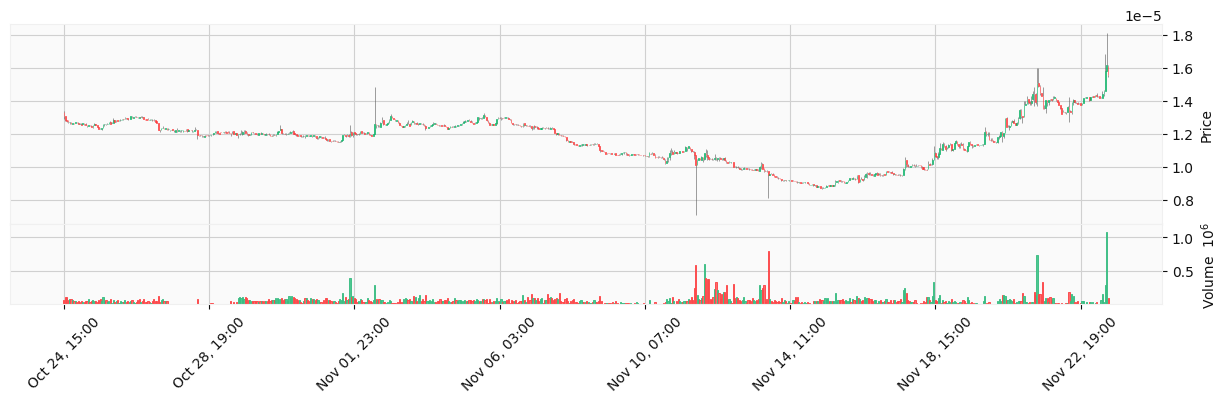

In [6]:
import mplfinance as mpl

df_candles: pd.DataFrame = df_trades.resample(rule="1h", on="time").agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    volume=("qty_abs", "sum")
)

mpl.plot(
    df_candles, type="candle", style="yahoo", volume=True, figsize=(16, 4), warn_too_much_data=int(1e10)
)

In [7]:
df_trades_14d: pd.DataFrame = df_trades[
    (df_trades["time"] >= pump.time.floor("1h") - timedelta(days=14)) &
    (df_trades["time"] < pump.time.floor("1h") - timedelta(days=1)) 
].copy()

df_trades_1d: pd.DataFrame = df_trades[
    df_trades["time"] >= pump.time.floor("1h") - timedelta(days=1)
].copy()

<h4>Imbalance ratio features</h4>

In [8]:
df_imbalance: pd.DataFrame = df_trades_1d.resample(rule="1h", on="time").agg(
    net_position=("qty_sign", "sum"),
    overall_vol=("qty_abs", "sum")
).reset_index()

df_imbalance["imbalance_ratio_1h"] = df_imbalance["net_position"] / df_imbalance["overall_vol"]
df_imbalance

,time,net_position,overall_vol,imbalance_ratio_1h
0,2021-11-22 15:00:00,-6556.0,30686.0,-0.213648
1,2021-11-22 16:00:00,1243.0,32085.0,0.038741
2,2021-11-22 17:00:00,999.0,55415.0,0.018028
3,2021-11-22 18:00:00,602.0,6382.0,0.094328
4,2021-11-22 19:00:00,-5772.0,15550.0,-0.371190
5,2021-11-22 20:00:00,2226.0,48622.0,0.045782
6,2021-11-22 21:00:00,21905.0,55329.0,0.395904
7,2021-11-22 22:00:00,-1257.0,9523.0,-0.131996
8,2021-11-22 23:00:00,10317.0,39529.0,0.260998
9,2021-11-23 00:00:00,574.0,9532.0,0.060218


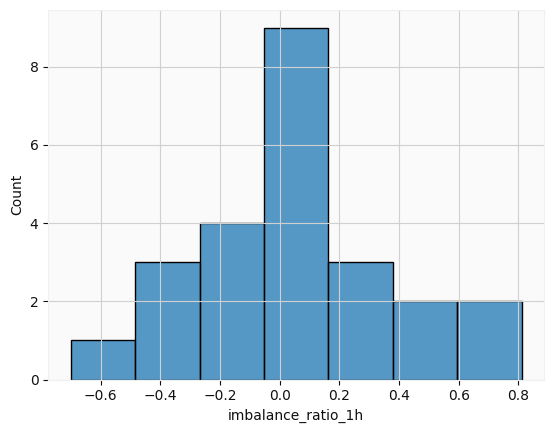

In [9]:
sns.histplot(data=df_imbalance["imbalance_ratio_1h"])
plt.show()

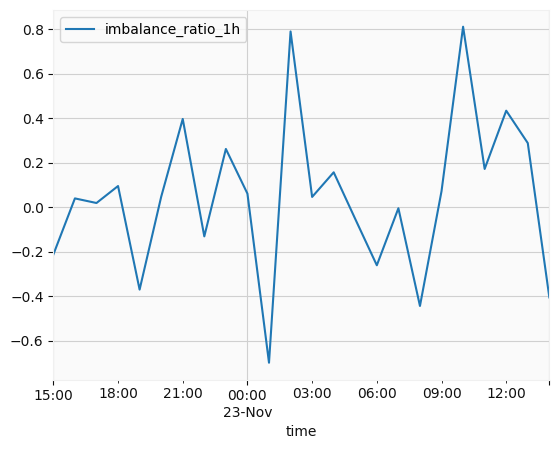

In [10]:
df_imbalance.plot(x="time", y="imbalance_ratio_1h")
plt.show()

In [11]:
from tsfresh.feature_extraction import extract_features, EfficientFCParameters, MinimalFCParameters

df_imbalance["id"] = 1

X_imbalance = extract_features(
    df_imbalance, n_jobs=1, column_id="id", column_sort="time", column_value="imbalance_ratio_1h",
    disable_progressbar=True,
    default_fc_parameters=MinimalFCParameters()
)

X_imbalance

,imbalance_ratio_1h__sum_values,imbalance_ratio_1h__median,imbalance_ratio_1h__mean,imbalance_ratio_1h__length,imbalance_ratio_1h__standard_deviation,imbalance_ratio_1h__variance,imbalance_ratio_1h__root_mean_square,imbalance_ratio_1h__maximum,imbalance_ratio_1h__absolute_maximum,imbalance_ratio_1h__minimum
1,1.088443,0.045553,0.045352,24.0,0.349241,0.12197,0.352174,0.81041,0.81041,-0.699869


<h4>Studying upper quantiles of trades</h4>

In [12]:
pump.time

Timestamp('2021-11-23 15:00:24')

In [13]:
df_trades.tail(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long
90327,2021-11-23 14:29:22.621,0.000016,0.000016,0.000016,0.000016,12.0,12.0,0.000187,0.000187,True
90328,2021-11-23 14:29:22.712,0.000016,0.000016,0.000016,0.000016,-330.0,330.0,-0.005131,0.005131,False


In [14]:
pump.time.floor("1h") - timedelta(days=1)

Timestamp('2021-11-22 15:00:00')

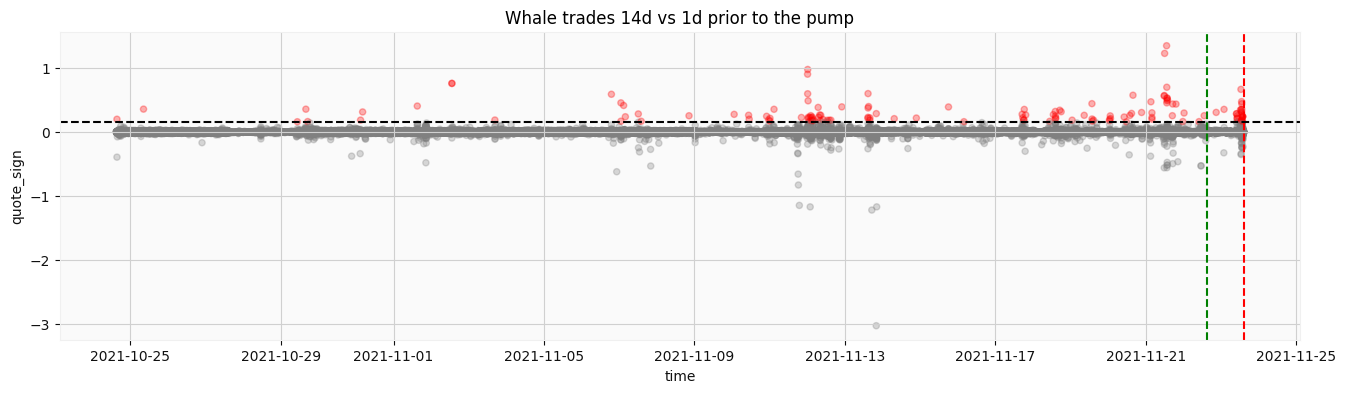

In [15]:
# define long whale volume
long_whale_quantile: float = df_trades_14d[df_trades_14d["is_long"]]["quote_abs"].quantile(.995)
df_trades["is_long_whale"] = df_trades["quote_sign"] >= long_whale_quantile

colors = df_trades["is_long_whale"].map({
    True: "red", False: "grey"
}).tolist()

df_trades.plot.scatter(
    x="time", y="quote_sign", figsize=(16, 4), alpha=.3, c=colors
)

plt.axvline(x=pump.time.floor("1h") - timedelta(days=1), color="green", linestyle="--")
plt.axvline(x=pump.time, color="red", linestyle="--")

plt.title("Whale trades 14d vs 1d prior to the pump")
plt.axhline(y=long_whale_quantile, color="black", linestyle="--")
plt.show()

In [16]:
df_trades_1d["is_long_whale"] = df_trades_1d["quote_sign"] >= long_whale_quantile
df_trades_14d["is_long_whale"] = df_trades_14d["quote_sign"] >= long_whale_quantile

In [17]:
# number of whale trades has increased 1 day prior to the pump, therefore we might create a feature 
# measuring this difference between 7d and 1d prior to the pump 

whale_quote_abs_mean_1d: float = df_trades_1d[df_trades_1d["is_long_whale"]]["quote_abs"].mean()
whale_quote_abs_mean_7d: float = df_trades_14d[df_trades_14d["is_long_whale"]]["quote_abs"].mean()

whale_quote_abs_mean_1d / whale_quote_abs_mean_7d

0.8655401321789223

In [18]:
df_trades_14d["time"].iloc[0]

Timestamp('2021-11-09 15:00:24.807000')

In [19]:
# number of whale trades
daily_avg_num_long_whale_trades: float = df_trades_14d.resample(rule="1d", on="time", label="left", closed="left").agg(
    num_long_whale_trades=("is_long_whale", "sum")
).mean().iloc[0]

# number of whale trades 1day prior to the pump
num_long_whale_trades_1d: int = df_trades_1d["is_long_whale"].sum()

num_long_whale_trades_1d / daily_avg_num_long_whale_trades

3.8969072164948453

<h4>Upper quantile volume</h4>

In [20]:
whale_overall_vol_1d: float = df_trades_1d[df_trades_1d["is_long_whale"]]["quote_abs"].sum()
df_trades_14d["long_whale_quote_abs"] =df_trades_14d["quote_abs"] *df_trades_14d["is_long_whale"]

#  average volume spent by whales in quote asset for longs
daily_avg_long_whale_vol: float =df_trades_14d.resample(
    rule="1d", on="time", label="left", closed="left", 
).agg(
    whale_overall_vol=("long_whale_quote_abs", "sum")
).mean().iloc[0]

long_whale_vol_1d: float = df_trades_1d[df_trades_1d["is_long_whale"]]["quote_abs"].sum()

long_whale_vol_1d / daily_avg_long_whale_vol

3.372929587253944

<h4>Std quote_abs ratio 1d and 7d prior to the pump</h4>

In [21]:
quote_abs_std_1d: float = df_trades_1d["quote_abs"].std()
quote_abs_std_7d: float = df_trades_14d["quote_abs"].std()

# divide short run 1d quote_abs_std by long run 7d std
quote_abs_std_1d, quote_abs_std_7d, quote_abs_std_1d / quote_abs_std_7d

(0.029610358880315445, 0.03132514586270896, 0.9452584517911253)

<h4>Whale long vs short quantile long run vs short run</h4>

In [22]:
# find short whale quantile .999 for long run
short_whale_quantile: float = df_trades_14d[~df_trades_14d["is_long"]]["quote_abs"].quantile(.995)

df_trades["is_short_whale"] = df_trades["quote_sign"] <= -short_whale_quantile
df_trades_1d["is_short_whale"] = df_trades_1d["quote_sign"] <= -short_whale_quantile
df_trades_14d["is_short_whale"] = df_trades_14d["quote_sign"] <= -short_whale_quantile

In [23]:
# whale imbalance on short run set
net_whale_position: float = df_trades_1d[
    df_trades_1d["is_short_whale"] | df_trades_1d["is_long_whale"]
]["quote_sign"].sum()

abs_whale_position: float = df_trades_1d[
    df_trades_1d["is_short_whale"] | df_trades_1d["is_long_whale"]
]["quote_abs"].sum()

net_whale_position, abs_whale_position

whale_imbalance_ratio_1d = net_whale_position / abs_whale_position
whale_imbalance_ratio_1d

0.44879787847096764

In [24]:
# 7d average daily imbalance ratio
df_whale_14d_imbalance: pd.DataFrame = df_trades_14d[
    df_trades_14d["is_short_whale"] | df_trades_14d["is_long_whale"]
].resample(rule="1d", on="time", label="left", closed="left").agg(
    whale_net_position=("quote_sign", "sum"),
    whale_abs_position=("quote_abs", "sum")
)

avg_daily_whale_imbalance_ratio_14d = (
    df_whale_14d_imbalance["whale_net_position"] / df_whale_14d_imbalance["whale_abs_position"]
).mean()

avg_daily_whale_imbalance_ratio_14d

0.09103533430477596

In [25]:
whale_offset_towards_the_pump: float = whale_imbalance_ratio_1d / avg_daily_whale_imbalance_ratio_14d
whale_offset_towards_the_pump

4.9299305802343

<h4>Log returns features</h4>

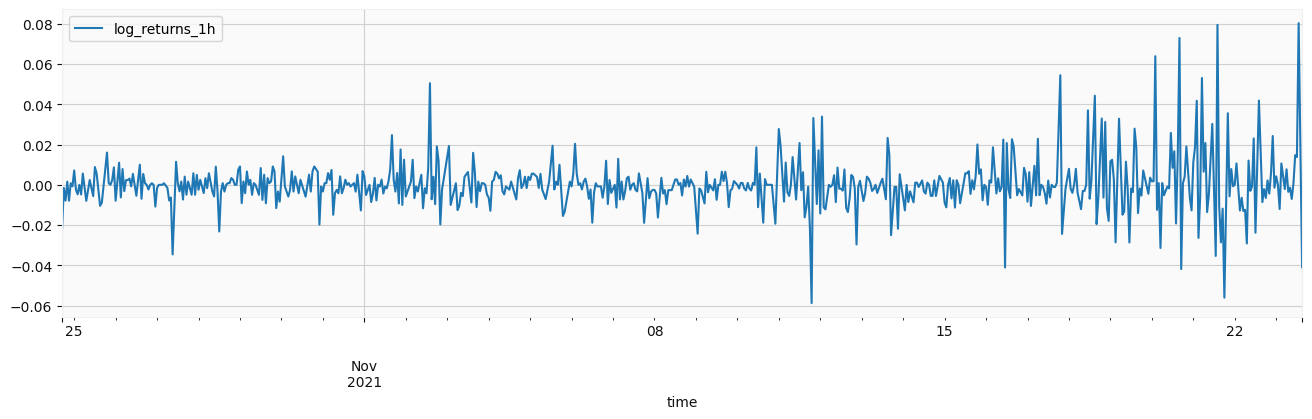

In [26]:
df_trades_1h: pd.DataFrame = df_trades.resample(
    rule="1h", on="time", label="right", closed="right"
).agg(
    qty_abs_1h=("qty_abs", "sum"),
    price_first=("price_first", "first"),
    price_last=("price_last", "last"),
    num_trades_1h=("qty_sign", "count"),
    quote_abs_1h=("quote_abs", "sum"),
)

# calculate log returns
df_trades_1h["price_last"] = df_trades_1h["price_last"].ffill()
df_trades_1h["log_returns_1h"] = np.log(
    df_trades_1h["price_last"] / df_trades_1h["price_last"].shift(1)
)
df_trades_1h = df_trades_1h[df_trades_1h["log_returns_1h"].notna()]
df_trades_1h = df_trades_1h.reset_index()

df_trades_1h.plot(x="time", y="log_returns_1h", figsize=(16, 4))
plt.show()

In [27]:
offsets: List[timedelta] = [
    timedelta(days=day) for day in [1, 7, 14]
]

labels: List[str] = ["1d", "7d", "14d"]

log_return_1h_std_30d: float = df_trades_1h[
    df_trades_1h["time"] >= pump.time.floor("1h") - timedelta(days=30)
]["log_returns_1h"].std()

log_returns_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_window: pd.DataFrame = df_trades_1h[
        df_trades_1h["time"] > pump.time.floor("1h") - offset
    ].copy()

    log_returns_1h_mean_scaled_by_std_30: float = df_window["log_returns_1h"].mean() / log_return_1h_std_30d
    log_returns_1h_std_scaled_by_std_30: float = df_window["log_returns_1h"].std() / log_return_1h_std_30d

<h4>Slippage loss in quote asset</h4>


$$\text{BTC\_lost\_to\_slippage} = \underbrace{\sum_{i=1}^{N}{\text{qty\_sign}_i} \cdot P_i}_{\text{Quote actually spent}} - \underbrace{\sum_{i=1}^N{\text{qty\_sign}_i} \cdot P_0}_{\text{Quote could have been spent if filled at best price}}$$

In [28]:
df_trades["quote_slippage"] = df_trades["quote_sign"] - df_trades["qty_sign"] * df_trades["price_first"]
# calculate loss for sell and buy sides

df_trades

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long,is_long_whale,is_short_whale,quote_slippage
0,2021-10-24 15:01:10.239,0.000013,0.000013,0.000013,0.000013,293.0,293.0,0.003912,0.003912,True,False,False,0.0
1,2021-10-24 15:02:28.510,0.000013,0.000013,0.000013,0.000013,-14.0,14.0,-0.000187,0.000187,False,False,False,0.0
2,2021-10-24 15:03:26.185,0.000013,0.000013,0.000013,0.000013,172.0,172.0,0.002296,0.002296,True,False,False,0.0
3,2021-10-24 15:04:02.979,0.000013,0.000013,0.000013,0.000013,-14.0,14.0,-0.000187,0.000187,False,False,False,0.0
4,2021-10-24 15:05:42.690,0.000013,0.000013,0.000013,0.000013,-373.0,373.0,-0.004976,0.004976,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90324,2021-11-23 14:29:14.445,0.000015,0.000015,0.000015,0.000015,319.0,319.0,0.004929,0.004929,True,False,False,0.0
90325,2021-11-23 14:29:16.474,0.000015,0.000015,0.000015,0.000015,223.0,223.0,0.003448,0.003448,True,False,False,0.0
90326,2021-11-23 14:29:16.901,0.000015,0.000015,0.000015,0.000015,375.0,375.0,0.005801,0.005801,True,False,False,0.0
90327,2021-11-23 14:29:22.621,0.000016,0.000016,0.000016,0.000016,12.0,12.0,0.000187,0.000187,True,False,False,0.0


In [29]:
from tsfresh.feature_extraction import extract_features, EfficientFCParameters, MinimalFCParameters

df_trades["id"] = 1

X_imbalance = extract_features(
    df_trades, n_jobs=1, column_id="id", column_sort="time", column_value="quote_sign",
    disable_progressbar=True,
    default_fc_parameters=EfficientFCParameters()
)

X_imbalance

,quote_sign__variance_larger_than_standard_deviation,quote_sign__has_duplicate_max,quote_sign__has_duplicate_min,quote_sign__has_duplicate,quote_sign__sum_values,quote_sign__abs_energy,quote_sign__mean_abs_change,quote_sign__mean_change,quote_sign__mean_second_derivative_central,quote_sign__median,...,quote_sign__fourier_entropy__bins_5,quote_sign__fourier_entropy__bins_10,quote_sign__fourier_entropy__bins_100,quote_sign__permutation_entropy__dimension_3__tau_1,quote_sign__permutation_entropy__dimension_4__tau_1,quote_sign__permutation_entropy__dimension_5__tau_1,quote_sign__permutation_entropy__dimension_6__tau_1,quote_sign__permutation_entropy__dimension_7__tau_1,quote_sign__query_similarity_count__query_None__threshold_0.0,quote_sign__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,1.0,7.060961,51.671881,0.009528,-1.001135e-07,-6.752079e-09,0.00003,...,0.610056,1.210467,3.236788,1.790358,3.172998,4.776207,6.555715,8.465772,NaN,1.476158
